<a href="https://colab.research.google.com/github/cleysonl/Fast-Ai/blob/master/lesson3_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the Data

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [6]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [7]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
# With TextDataBunch tokenization and numericalization is done behind scenes
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

### Tokenization

In [11]:
data = TextDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


### Numericalization

In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [13]:
data.train_ds[0][0].data[:10]

array([   2,    5, 2812,    0,   18,    5, 1834,  729,   13, 1376])

### Data Block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

In [0]:
data = (TextList.from_csv(path, 'texts.csv',cols = 'text')
       .split_from_df(col=2)
       .label_from_df(cols=0)
       .databunch())

### Language model

In [0]:
bs =48

In [16]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [17]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg')]

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called wikitext-103).

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of TextDataBunch for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [21]:
data_lm.show_batch()

idx,text
0,"it just would n't have been the same . dey young , clint howard , xxmaj vincent xxmaj van xxmaj patten , xxmaj mary xxmaj woronov , xxmaj paul xxmaj bartel , and the hall xxunk , just added to the movie . xxmaj the whole entire movie is about xxmaj the xxmaj ramones ... especially xxmaj joey ! xxmaj so everybody showed see xxmaj rock ' n ' xxmaj"
1,"that they would turn youths into half - mad juvenile delinquents . xxmaj this film , developed from key questions raised in her life , poses dilemmas that are as relevant today as back in 1950 . \n \n xxmaj our film opens with two key scenes . xxmaj in the first , we see well - dressed , respectable looking men in a seedy bookshop . xxmaj one"
2,"wonderfully spooky film . xxmaj this was a thesis project for the writer / director , xxup jt xxmaj petty . xxmaj he did a great job of having me on the edge of my seat . i never really knew what to expect , and for a jaded horror - movie goer , this is xxmaj nirvana ! xxmaj the film concerns an elderly man who lives in a"
3,"xxmaj and often very moving style at that : affecting , charming and cross - generational . xxmaj that a lot xxmaj anime ( speaking in broad terms ) and a great many other animations fail to match their technical virtuosity with real substance is , i think ( and i might be wrong ) partly because either the makers are n't bothered with character and plot and focus far"
4,"appeal . xxmaj and even though there 's a xxmaj great deal of money at stake it 's fun . xxmaj the pressure ( stress ) that exists in most game shows does xxup not exist here . xxmaj several people who posted messages complained how much time is waisted with the dancers & choosing questions , & c , like xxmaj millionaire does n't have similar time wasters ."


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


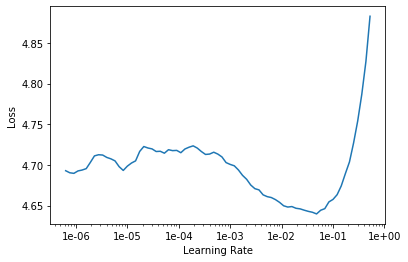

In [26]:
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(1,1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
learn.save('fine_tuned')

In [0]:
TEXT = 'I like this movie because'
N_WORDS = 40
N_SENTENCES = 2

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()